# Contextual bandit

What is the optimal policy for a one-dimensional contextual bandit environment with a bimodal reward-state distribution?

## Define environment

# Hyperparameters: constant

- Standard deviation of normal distributions $\sigma$
- Relative weightings of the two distributions in the mix $p$

### Hyperparameters: variable

- Midpoint between the means of the normal distributions
- Separation between the means of the normal distributions

### Parameters

- Environmental state (feature / context / cue) $s$ (see [Hyperparameters: variable](#hyperparameters-variable))
- Action choice $a$ 
- Probability of a reward $P(r|s,a)$
- Actual reward in a given instance $R(s,a)$

### Implications of single-timestep episodes

- There's no model of the environment because there are no state transitions (and episode initialisations are random)
- Could be considered a *nonstationary* problem because the expected rewards are changing each episode (even though the hyperdistribution from which those expected rewards are sampled is fixed)

In [2]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.distributions import Normal, Bernoulli
from tqdm.notebook import tqdm

# import jax.numpy as jnp
import matplotlib.pyplot as plt
# from jax.scipy.stats import norm
# import jax.random
# from jax.nn import softmax, sigmoid

# from jax import grad, value_and_grad, vmap
# from flax import linen as nn
# import optax

In [8]:
class BimodalBandit:
    def __init__(self, midpoint, distance, seed, sigma=1, p=0.5):
        self.midpoint = midpoint
        self.distance = distance
        self.p = p
        self.sigma = sigma
        self.mu1 = midpoint - distance / 2
        self.mu2 = midpoint + distance / 2
        torch.manual_seed(seed)

    def define_reward_probability(self, action):
        # action is now expected to be a Tensor directly
        reward_probability = self.p * Normal(self.mu1, self.sigma).log_prob(action).exp() + \
                             (1 - self.p) * Normal(self.mu2, self.sigma).log_prob(action).exp()
        return reward_probability

    def simulate_reward(self, action):
        reward_probability = self.define_reward_probability(action)
        reward = Bernoulli(reward_probability).sample().int()
        return reward

# Ensure action_space is a tensor; this is already the case
action_space = torch.linspace(-10, 10, 4000).view(-1, 1)

# Adjustments for tensor operations
torch.manual_seed(0)
midpoint = 0
distance = 4
bandit = BimodalBandit(midpoint=midpoint, distance=distance, seed=0)

# reward_probabilities = bandit.define_reward_probability(action_space)
# simulated_rewards = torch.tensor([bandit.simulate_reward(action_space[i]).item() for i in range(action_space.size(0))]).float().view(-1, 1)

reward_probabilities = torch.tensor([bandit.define_reward_probability(action).item() for action in action_space])
simulated_rewards = torch.tensor([bandit.simulate_reward(action).item() for action in action_space]).float().view(-1, 1)


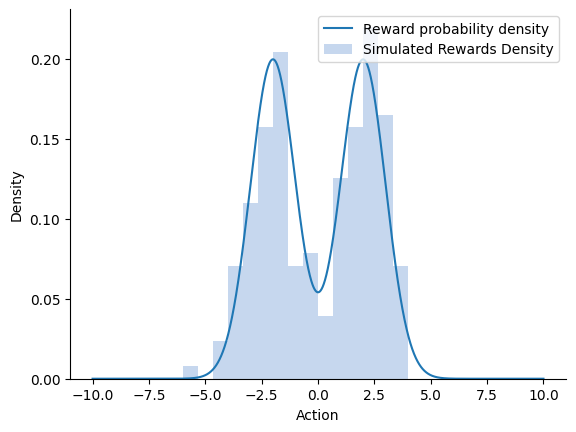

In [9]:
def plot_bimodal_bandit(action_space, reward_probabilities, simulated_rewards, ax=None):
    # If no specific axis is provided, create a new figure and axis
    if ax is None:
        fig, ax = plt.subplots()

    colors = ['#1f77b4', '#aec7e8']  # Blue color palette

    ax.set_xlabel('Action')
    ax.set_ylabel('Density')

    # Plot the PDF on the provided axis
    ax.plot(action_space.numpy(), reward_probabilities.numpy(), color=colors[0], label='Reward probability density')

    # Ensure action_space and simulated_rewards are compatible with histogram plotting
    # The histogram expects a flat array for x; use numpy() to convert tensors to numpy arrays
    # For weights, it's crucial that the length matches the action_space's flattened array
    simulated_rewards_flat = simulated_rewards.flatten()

    # Normalize simulated_rewards for density plot
    simulated_rewards_density = simulated_rewards_flat / simulated_rewards_flat.sum()

    ax.hist(action_space.numpy().flatten(), 
            weights=simulated_rewards_density.numpy(), 
            bins=30, alpha=0.7, 
            color=colors[1], 
            density=True, 
            label='Simulated Rewards Density')

    # Add a legend to the provided axis
    ax.legend()

    # Create L-shaped box on the provided axis
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Show the plot only if we're not plotting on an existing axis
    if ax is None:
        plt.show()

# Call the corrected plot_bimodal_bandit function
plot_bimodal_bandit(action_space, reward_probabilities, simulated_rewards)


### Key steps
1. **Sample** trajectories
2. **Fit** a model (e.g. environment / value function)
3. **Improve** the policy

In [12]:
# Neural Network Definition
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Training function with lambda_reg_l1 and lambda_reg_l2 as parameters
def train_model(model, optimizer, actions, rewards, epochs=1000, lambda_reg_l1=0.0001, lambda_reg_l2=0.001):
    losses = []
    for epoch in tqdm(range(epochs), desc="Training Progress"):
        model.train()  # Set the model to training mode
        optimizer.zero_grad()
        logits = model(actions)
        loss = F.binary_cross_entropy_with_logits(logits, rewards, reduction='mean')
        l1_penalty = sum(torch.abs(param).sum() for param in model.parameters())
        l2_penalty = sum(torch.square(param).sum() for param in model.parameters())
        total_loss = loss + lambda_reg_l1 * l1_penalty + lambda_reg_l2 * l2_penalty
        total_loss.backward()
        optimizer.step()
        losses.append(total_loss.item())

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {total_loss.item()}")
    
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        logits = model(actions)
        probabilities = torch.sigmoid(logits)

    return probabilities, losses



In [16]:
# Parameters to iterate over
lambda_reg_l1_values = [0.0, 0.0001, 0.001]
lambda_reg_l2_values = [0.0, 0.0001, 0.001]
results = {}

# Iterating over combinations of lambda_reg_l1 and lambda_reg_l2
for l1 in lambda_reg_l1_values:
    for l2 in lambda_reg_l2_values:
        print(f"Training with L1: {l1}, L2: {l2}")
        model = SimpleNN()
        optimizer = optim.Adam(model.parameters(), lr=0.01)
        probabilities, losses = train_model(model, optimizer, action_space, simulated_rewards, epochs=500, lambda_reg_l1=l1, lambda_reg_l2=l2)
        results[(l1, l2)] = {'probabilities': probabilities, 'losses': losses}

Training with L1: 0.0, L2: 0.0


Training Progress:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0, Loss: 0.7473639249801636
Epoch 100, Loss: 0.15538768470287323
Epoch 200, Loss: 0.1488410383462906
Epoch 300, Loss: 0.14584466814994812
Epoch 400, Loss: 0.14437207579612732
Training with L1: 0.0, L2: 0.0001


Training Progress:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0, Loss: 0.560147762298584
Epoch 100, Loss: 0.15871332585811615
Epoch 200, Loss: 0.15205161273479462
Epoch 300, Loss: 0.1504555493593216
Epoch 400, Loss: 0.14768396317958832
Training with L1: 0.0, L2: 0.001


Training Progress:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0, Loss: 0.9649194478988647
Epoch 100, Loss: 0.17968615889549255
Epoch 200, Loss: 0.1659129410982132
Epoch 300, Loss: 0.16234466433525085
Epoch 400, Loss: 0.1606072634458542
Training with L1: 0.0001, L2: 0.0


Training Progress:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0, Loss: 0.5343421697616577
Epoch 100, Loss: 0.16998742520809174
Epoch 200, Loss: 0.1600438952445984
Epoch 300, Loss: 0.15583743155002594
Epoch 400, Loss: 0.1553419530391693
Training with L1: 0.0001, L2: 0.0001


Training Progress:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0, Loss: 0.8666661381721497
Epoch 100, Loss: 0.18307806551456451
Epoch 200, Loss: 0.1680242419242859
Epoch 300, Loss: 0.16094174981117249
Epoch 400, Loss: 0.1588805764913559
Training with L1: 0.0001, L2: 0.001


Training Progress:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0, Loss: 0.7947288155555725
Epoch 100, Loss: 0.1843961477279663
Epoch 200, Loss: 0.16847313940525055
Epoch 300, Loss: 0.16501785814762115
Epoch 400, Loss: 0.16479013860225677
Training with L1: 0.001, L2: 0.0


Training Progress:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0, Loss: 0.8381385207176208
Epoch 100, Loss: 0.21017295122146606
Epoch 200, Loss: 0.19002977013587952
Epoch 300, Loss: 0.18343621492385864
Epoch 400, Loss: 0.17813140153884888
Training with L1: 0.001, L2: 0.0001


Training Progress:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0, Loss: 0.7927788496017456
Epoch 100, Loss: 0.20853568613529205
Epoch 200, Loss: 0.1933838129043579
Epoch 300, Loss: 0.18903233110904694
Epoch 400, Loss: 0.1862565577030182
Training with L1: 0.001, L2: 0.001


Training Progress:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0, Loss: 0.9926573038101196
Epoch 100, Loss: 0.21501979231834412
Epoch 200, Loss: 0.20030474662780762
Epoch 300, Loss: 0.1968804895877838
Epoch 400, Loss: 0.19365331530570984


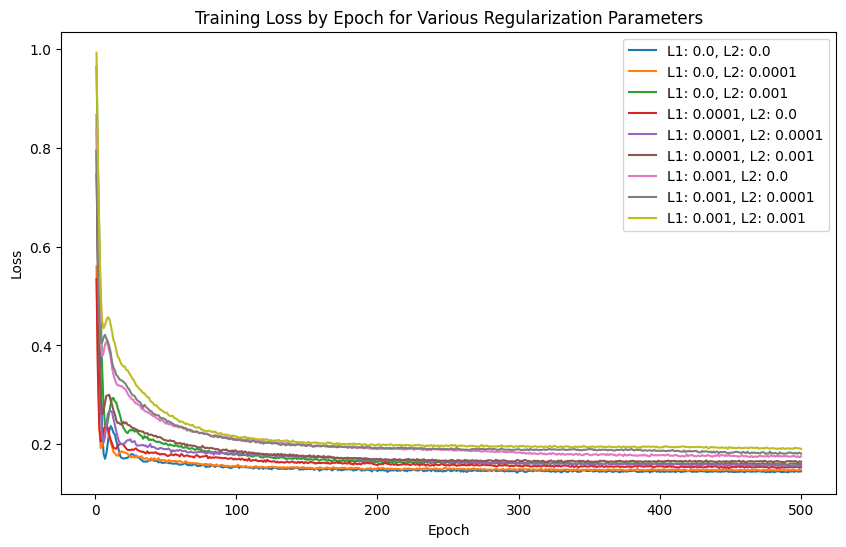

In [17]:
plt.figure(figsize=(10, 6))

for (l1, l2), data in results.items():
    losses = data['losses']
    epochs = range(1, len(losses) + 1)
    plt.plot(epochs, losses, label=f'L1: {l1}, L2: {l2}')

plt.title('Training Loss by Epoch for Various Regularization Parameters')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


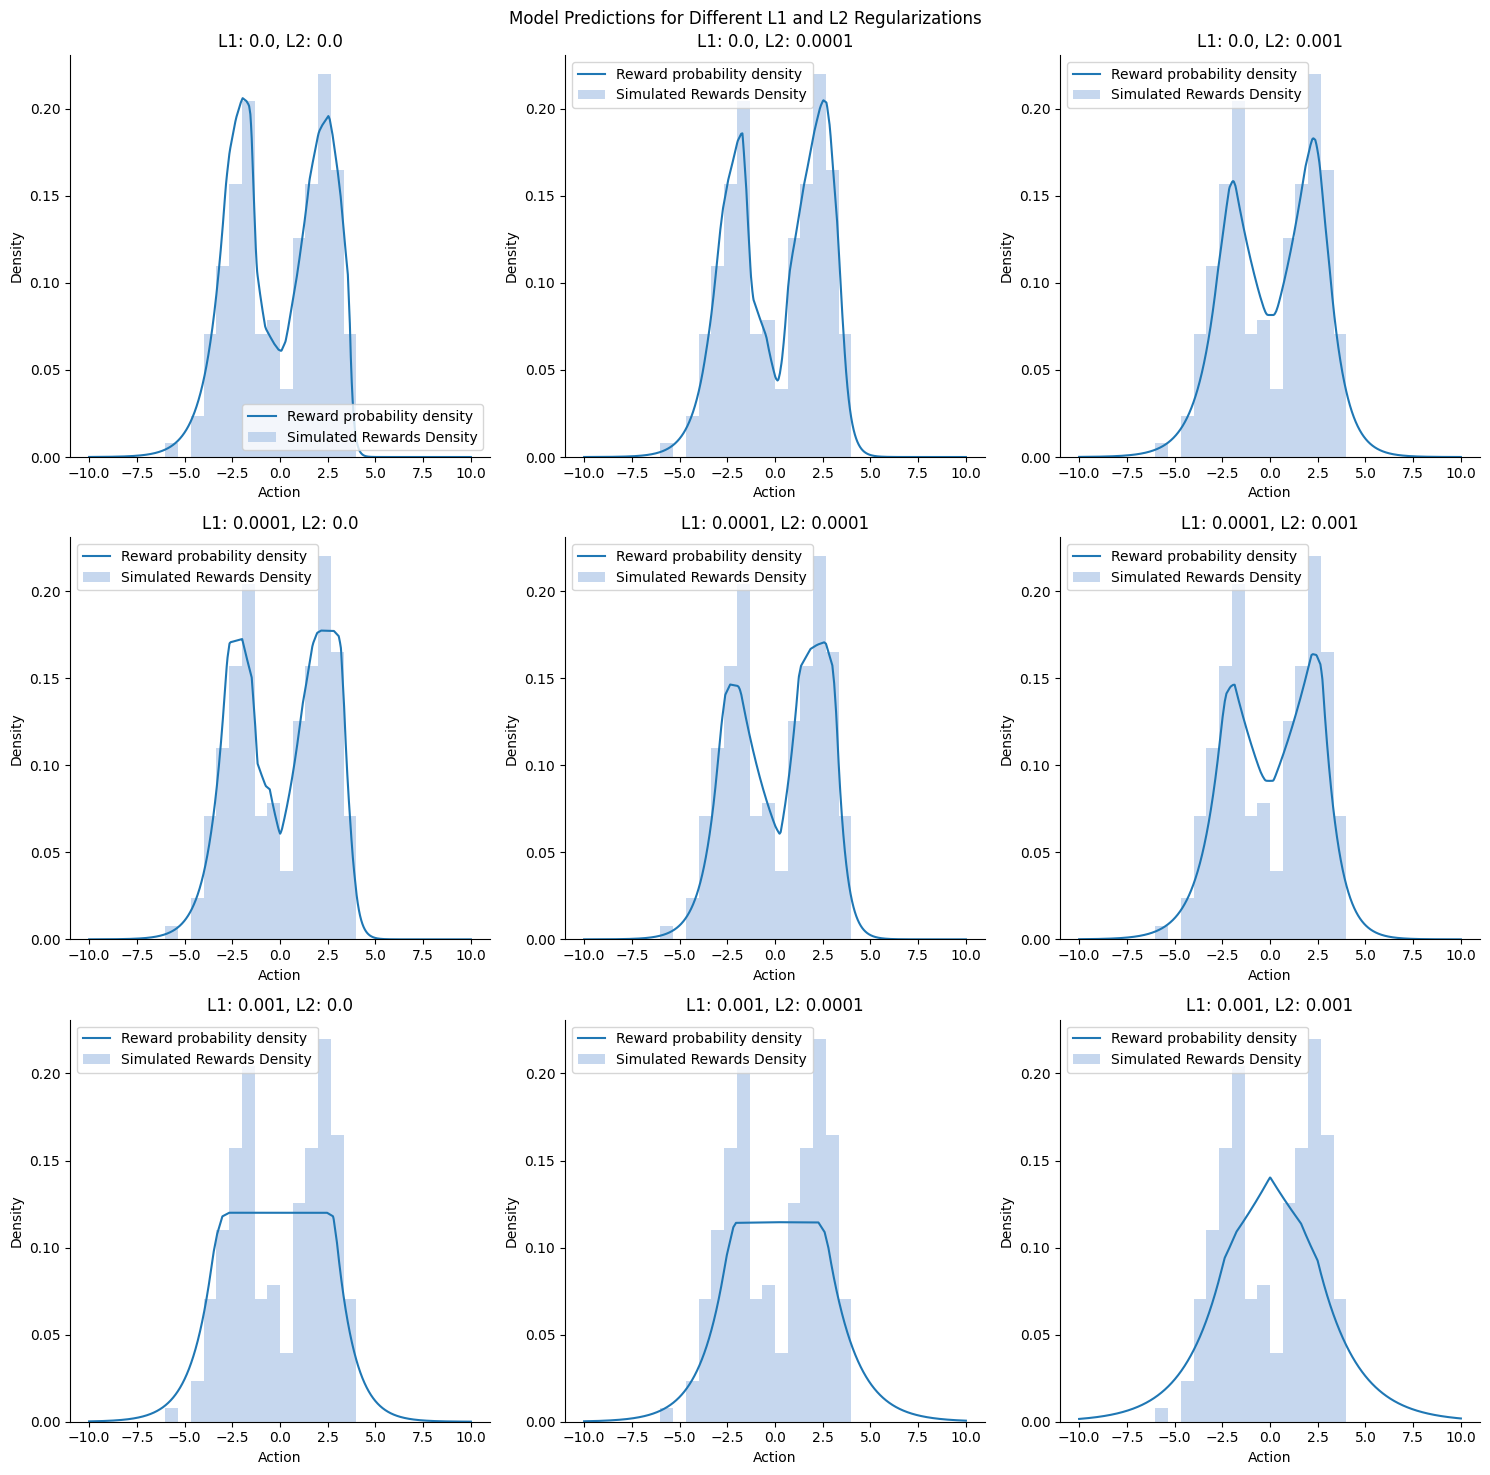

In [18]:
# Number of rows and columns for the subplot grid
num_rows = len(lambda_reg_l1_values)
num_columns = len(lambda_reg_l2_values)

# Create a figure for the subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(5 * num_columns, 5 * num_rows))
fig.suptitle('Model Predictions for Different L1 and L2 Regularizations')

# Check if we have a single row/column to avoid indexing issues
if num_rows == 1 or num_columns == 1:
    axes = np.array(axes).reshape(num_rows, -1)

# Loop through all combinations of L1 and L2 values
for i, l1 in enumerate(lambda_reg_l1_values):
    for j, l2 in enumerate(lambda_reg_l2_values):
        ax = axes[i, j] if num_rows > 1 and num_columns > 1 else axes[max(i, j)]
        # Adjusting how probabilities are accessed based on the new results format
        probabilities = results[(l1, l2)]['probabilities']
        
        plot_bimodal_bandit(action_space, probabilities, simulated_rewards, ax=ax) 
        ax.set_title(f'L1: {l1}, L2: {l2}')

# Adjust layout so titles and labels don't overlap
plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Adjust the top spacing to accommodate the main title
plt.show()


## TODO

### Define policy
- Inputs: state $s$
- Outputs: action $a$

### Generate reward samples 
- Generate action according to the policy
- Sample rewards from those action

### Estimate value of action
- Since each episode is one timestep, total return = reward at $t{0}$

### Update the policy 
- RL: gradient descent (batch size = full sample)
- EA: geometric mean?
- Minimax: regret

How should the EA and minimax updates be calculated?

### Action effects on environment (full MDP)
- Transition (environmental feedback) dynamics $P(s'|a,s)$
- Discount rate $\gamma$